In [1]:
import yaml
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt
from nets import Generator, Discriminator, load_Generator, load_Discriminator
from config.load_config import load_config

%load_ext autoreload
%autoreload 2

In [2]:
config = load_config()

In [3]:
from data import CIRDataset, GBMDataset
C = dict(S0=np.array([0.1, 0.2]), dt=np.array([1]))
# C = dict(dt=np.array([1]))
dataset = CIRDataset(params=CIRDataset.DEFAULT_PARAMS.update(gamma=0.1, S_bar=0.1), condition_ranges=C, test_params=dict(S0=0.1, dt=1))
# dataset = GBMDataset(params=GBMDataset.DEFAULT_PARAMS.update(dt=1), condition_ranges=C, test_params=dict(dt=1))
(Z, exact) = dataset.generate()

In [4]:
from data_types import Activation

# generator = load_Generator("./output/gbm/supervised/netG.pth",
# generator = load_Generator("./pre_trained_nets/high_gamma/supervised/netG.pth",
generator = load_Generator("./output/feller_satisfied/supervised/netG.pth",
                           c_dim=2 if dataset.SDE == 'CIR' else 1,
                           hidden_dim=200,
                           activation=Activation.LEAKY_RELU,
                           negative_slope=0.1)

# generator_vanilla = load_Generator("./output/gbm/vanilla/netG.pth",
# generator_vanilla = load_Generator("./output/feller_violated_high_gamma/vanilla/netG.pth",
# generator_vanilla = load_Generator("./pre_trained_nets/gbm/vanilla/netG.pth",
generator_vanilla = load_Generator("./output/feller_satisfied/vanilla/netG.pth",
                           c_dim=2 if dataset.SDE == 'CIR' else 1,
                           hidden_dim=200,
                           activation=Activation.LEAKY_RELU,
                           negative_slope=0.1)

In [5]:
from analysis import Analysis
from CGANalysis import CGANalysis
from sde_dataset import SDEDataset
from config.load_config import load_config
from presets import load_preset
from data_types import Preset

config = load_config("./config.yaml")

In [6]:
analysis = Analysis(dataset=dataset, generator=generator, config=config)

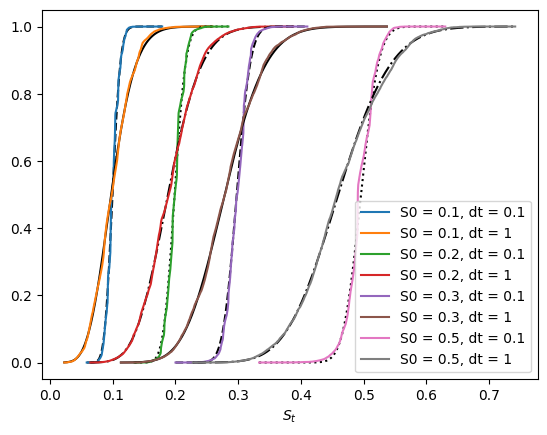

In [7]:
ax = analysis.plot(dict(S0=[0.1, 0.2, 0.3, 0.5], dt=[0.1, 1]), plot_type="ecdf", raw_output=False)
# ax = analysis.plot(dict(dt=[0.1, 1]), plot_type="ecdf", raw_output=False)
ax.legend()
# ax.set_xlim((0.8, 1.2))

# x = np.linspace(0, 2, 100)
# plt.plot(x, dataset.cdf(params={**dataset.params, **dataset.test_params})(x))

In [8]:
from data.dataset_base import DatasetBase


# def GBM_exact_paths(datasetDatasetBasese, S0):
#     Z = torch.randn((n_paths, n_steps))
#     mu = dataset.params['mu']
#     sigma = dataset.params['sigma']
#     dt = condition_dict['dt']

#     exact = torch.zeros((n_paths, n_steps+1))
#     exact[:, 0] = S0
#     exact[:, 1:] = (S0*np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z).cumprod(axis=1))
#     return Z, exact


# def CIR_exact_paths():
#     Z = torch.zeros((n_paths, n_steps))
#     paths_exact[:, 0] = S0 * torch.ones(1, n_paths)
#     for i in range(n_steps-1):
#         paths_exact[:, i+1] = dataset.sample_exact(n_paths,
#                                                 params={**dataset.params,
#                                                         **condition_dict,
#                                                         **dict(S0=paths_exact[:, i])
#                                                         }
#                                                 ).view(-1)
#         # Draw samples Z
#         cdf = dataset.cdf(params={**dataset.params, **condition_dict, **dict(S0=paths_exact[:, i])})
#         Z[:, i] = torch.tensor(stat.norm.ppf(cdf(paths_exact[:, i+1])), dtype=torch.float32)

#     # Z = torch.randn((n_paths, n_steps))
#     return Z, paths_exact

In [9]:
def weak_error(v1, v2):
    return np.abs(v1[:, -1].mean() - v2[:, -1].mean())

def strong_error(v1, v2):
    return np.abs(v1[:, -1] - v2[:, -1]).mean()

def calc_errors(v1, v2):
    return weak_error(v1, v2), strong_error(v1, v2)

In [10]:
import torch
from paths import make_gan_paths
from data_types import SchemeType
from data import DatasetBase

# np.where('b' == np.array(list(dict(a=1, b=2).keys())))[0][0]

n_paths = 10_000
S0 = 0.1
condition_dict = dict(S0=0.1, dt=0.5)
S_ref = S0
T = 2
n_steps_vec = np.array([40, 20, 10, 5, 4, 3, 2, 1])
dts = T / n_steps_vec
# condition_dict = dict(dt=1)

# pre-allocate
strong_err_Euler, weak_err_Euler = np.zeros(len(n_steps_vec)), np.zeros(len(n_steps_vec))
strong_err_Milstein, weak_err_Milstein = np.zeros(len(n_steps_vec)), np.zeros(len(n_steps_vec))
strong_err_GAN, weak_err_GAN = np.zeros(len(n_steps_vec)), np.zeros(len(n_steps_vec))

paths_stored = []

for k, dt in enumerate(dts):
    condition_dict.update(dt=dt)
    n_steps = n_steps_vec[k]

    paths_exact = torch.zeros((n_paths, n_steps))

    Z, paths_exact = dataset.make_paths(scheme=SchemeType.CIR_EXACT,
                                        n_steps=n_steps,
                                        params={**dataset.params, **condition_dict},
                                        n_paths=n_paths)

    _, paths_milstein = dataset.make_paths(scheme=SchemeType.CIR_MILSTEIN_HEFTER,
                                    n_steps=n_steps,
                                    params={**dataset.params, **condition_dict},
                                    Z=Z,
                                    n_paths=n_paths)

    _, paths_euler = dataset.make_paths(scheme=SchemeType.CIR_TRUNC_EULER,
                                    n_steps=n_steps,
                                    params={**dataset.params, **condition_dict},
                                    Z=Z,
                                    n_paths=n_paths)


    paths_gan = make_gan_paths(data=dataset,
                        G=generator,
                        n_steps=n_steps,
                        C=condition_dict,
                        Z=Z,
                        S_ref=S_ref,
                        proc_type=config.meta_parameters.proc_type)
    
    paths_stored.append(dict(gan=paths_gan,
                             euler=paths_euler,
                             milstein=paths_milstein,
                             exact=paths_exact)
                             )

    weak_err_Euler[k], strong_err_Euler[k] = calc_errors(paths_exact, paths_euler)
    weak_err_Milstein[k], strong_err_Milstein[k] = calc_errors(paths_exact, paths_milstein)
    weak_err_GAN[k], strong_err_GAN[k] = calc_errors(paths_exact, paths_gan)


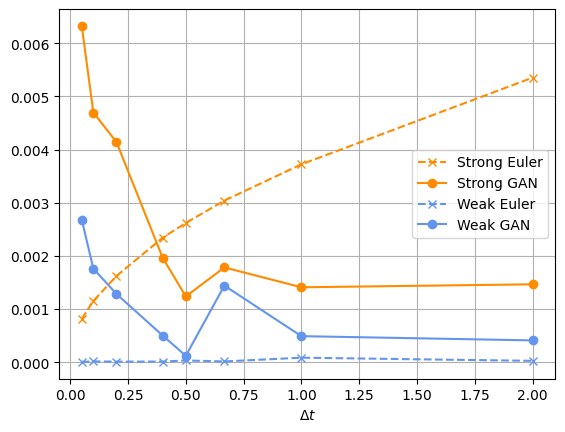

In [11]:

plt.figure(dpi=100)

plt.plot(dts, strong_err_Euler, label='Strong Euler', linestyle='--', color='DarkOrange', marker='x')
plt.plot(dts, strong_err_GAN, label='Strong GAN', linestyle='-', color='DarkOrange', marker='o')
plt.plot(dts, weak_err_Euler, label='Weak Euler', linestyle='--', color='cornflowerblue', marker='x')
plt.plot(dts, weak_err_GAN, label='Weak GAN', linestyle='-', color='cornflowerblue', marker='o')


plt.xlabel('$\Delta t$')
plt.legend()
plt.grid('on')


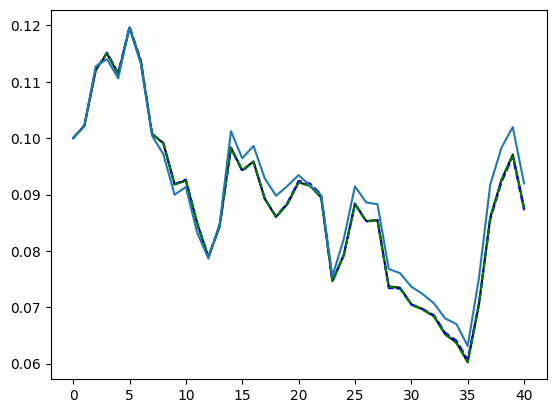

In [12]:
# Plot a path

n_steps_idx = 0
idx = 0

plt.plot(paths_stored[n_steps_idx]['exact'][idx, :], '-k')
plt.plot(paths_stored[n_steps_idx]['euler'][idx, :], '--b')
plt.plot(paths_stored[n_steps_idx]['milstein'][idx, :], '--g')
plt.plot(paths_stored[n_steps_idx]['gan'][idx, :], '-')

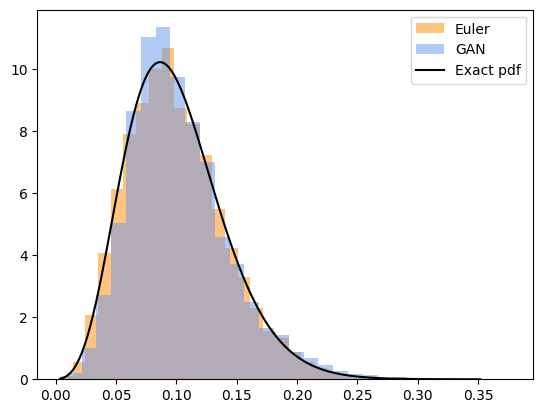

In [13]:
from utils import get_plot_bounds

pdf_T = dataset.pdf(params={**dataset.params,**dict(S0=S0, dt=n_steps_vec[n_steps_idx] * dts[n_steps_idx])})

a, b = get_plot_bounds(paths_stored[n_steps_idx]['exact'][:, -1])

x = np.linspace(a, b, 1000)

plt.figure(dpi=100)
_ = plt.hist(paths_stored[n_steps_idx]['euler'][:, -1],
             density=True,
             bins=30,
             color='darkorange',
             alpha=0.5,
             label='Euler')
_ = plt.hist(paths_stored[n_steps_idx]['gan'][:, -1],
             density=True,
             bins=30,
             color='cornflowerblue',
             alpha=0.5,
             label='GAN')

plt.plot(x, pdf_T(x), '-k', label='Exact pdf')
plt.legend()


(-1.2, 3.0)

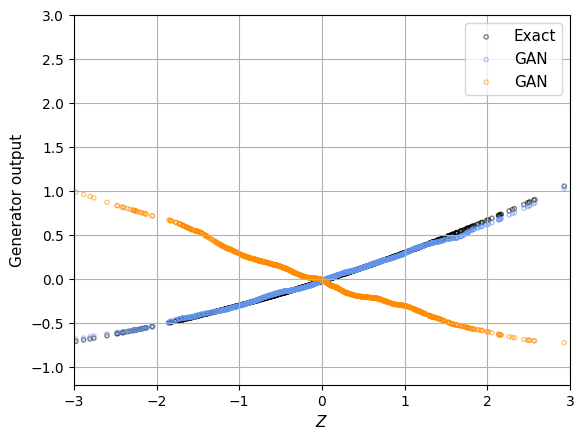

In [16]:
# Scatter plot supervised vs unsupervised

from sample import preprocess
from utils import make_test_tensor


C = dict(S0=np.array([0.1]), dt=np.array([1]))
n_plot = 1000
dataset_2 = CIRDataset(n=n_plot,
                       n_test=n_plot,
                       params=CIRDataset.DEFAULT_PARAMS.update(gamma=0.1, S_bar=0.1),
                       condition_ranges=C,
                       test_params=dict(S0=0.1, dt=1))

(Z_2, Y) = dataset_2.generate(params={**dataset_2.params, **dataset_2.test_params})

analysis_2 = Analysis(dataset=dataset_2, generator=generator, config=config, noise_samples=n_plot)
R_exact = preprocess(Y,
                     dataset_2.test_params['S0'],
                     proc_type=config.meta_parameters.proc_type,
                     S_ref=config.meta_parameters.S_ref,
                     eps=config.meta_parameters.eps,
                     )

R = analysis_2.infer(condition_dict=dataset_2.test_params,
                     generator=generator,
                     noise=Z_2,
                     )

R_vanilla = analysis_2.infer(condition_dict=dataset_2.test_params,
                     generator=generator_vanilla,
                     noise=Z_2,
                     )

# Make scatter plots 
plt.figure(dpi=100)
plt.scatter(Z_2.view(-1).cpu().numpy(),
            R_exact.view(-1).numpy(),
            label='Exact',
            alpha=0.5, 
            marker='.',
            facecolors='none',
            edgecolors='k')

plt.scatter(Z_2.view(-1).cpu().numpy(),
            R.view(-1).numpy(),
            label='GAN',
            alpha=0.5, 
            marker='.',
            facecolors='none',
            edgecolors='cornflowerblue')

plt.scatter(Z_2.view(-1).cpu().numpy(),
            R_vanilla.view(-1).numpy(),
            label='GAN',
            alpha=0.5, 
            marker='.',
            facecolors='none',
            edgecolors='darkorange')
# plt.scatter(Y.Z.view(-1).cpu().numpy(),output_vanilla[0:n_plot],label='Vanilla GAN',alpha=0.5,color='cornflowerblue')
# plt.scatter(Y.Z.view(-1).cpu().numpy(),output_supervised[0:n_plot],label='Supervised GAN',marker='o',alpha=1,facecolors='none',edgecolors='darkorange')

fs = 11
plt.xlabel('$Z$',fontsize=fs)
plt.ylabel('Generator output',fontsize=fs)
plt.legend(fontsize=fs)
plt.grid('on')
plt.xlim([-3,3])
plt.ylim([-1.2,3])